## 0. Setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine

c:\Users\sugab\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Get data

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create data loaders

### 2.1 Creating a transform for model (manual creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

In [5]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
# There are commonly transforms that use on torchvision.models
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x29993405790>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for model (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

Although we can manually create a transform to match the original training data, it's much easier to use transforms from the pretrained model's layer.

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that auto_transforms came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2999340fa10>,
 ['pizza', 'steak', 'sushi'])

## 3. Get pretrained model

### 3.1 Which pretrained model to use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means better performance but a larger model.

You might think better performance is always better, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

Understanding this **performance vs. speed vs. size** tradeoff will come with time and practice.

For now, we'll use `EfficientNetB0`, a good balance between performance and speed.

### 3.2 Setting up a pretrained model

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Our `efficientnet_b0` comes in three main parts:
- `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
- `avgpool` - Takes the average of the output of the features layer(s) and turns it into a feature vector.
- `classifier` - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

### 3.3 Summary of model

In [14]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freeze pretrained model weights

In [15]:
# freeze feature extractor layer weights
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

# change classifier layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True),
).to(device)

In [18]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [20]:
# Define loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

# train model
result = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss,
    optimizer=optimizer,
    epochs=5,
    device=device,
)

end_time = timer()
print(f"Time taken to train model: {end_time - start_time:.2f} seconds")

 20%|██        | 1/5 [00:34<02:18, 34.65s/it]


Epoch: 1 | train_loss: 1.0746 | train_acc: 0.4023 | test_loss: 0.9051 | test_acc: 0.6212


 40%|████      | 2/5 [01:05<01:37, 32.56s/it]


Epoch: 2 | train_loss: 0.8672 | train_acc: 0.7617 | test_loss: 0.7827 | test_acc: 0.8362


 60%|██████    | 3/5 [01:36<01:03, 31.64s/it]


Epoch: 3 | train_loss: 0.7661 | train_acc: 0.8320 | test_loss: 0.7307 | test_acc: 0.8561


 80%|████████  | 4/5 [02:07<00:31, 31.28s/it]


Epoch: 4 | train_loss: 0.7358 | train_acc: 0.7305 | test_loss: 0.6361 | test_acc: 0.8759


100%|██████████| 5/5 [02:37<00:00, 31.40s/it]


Epoch: 5 | train_loss: 0.6416 | train_acc: 0.7930 | test_loss: 0.6284 | test_acc: 0.8561
Time taken to train model: 157.01 seconds


## 5. Evaluate model

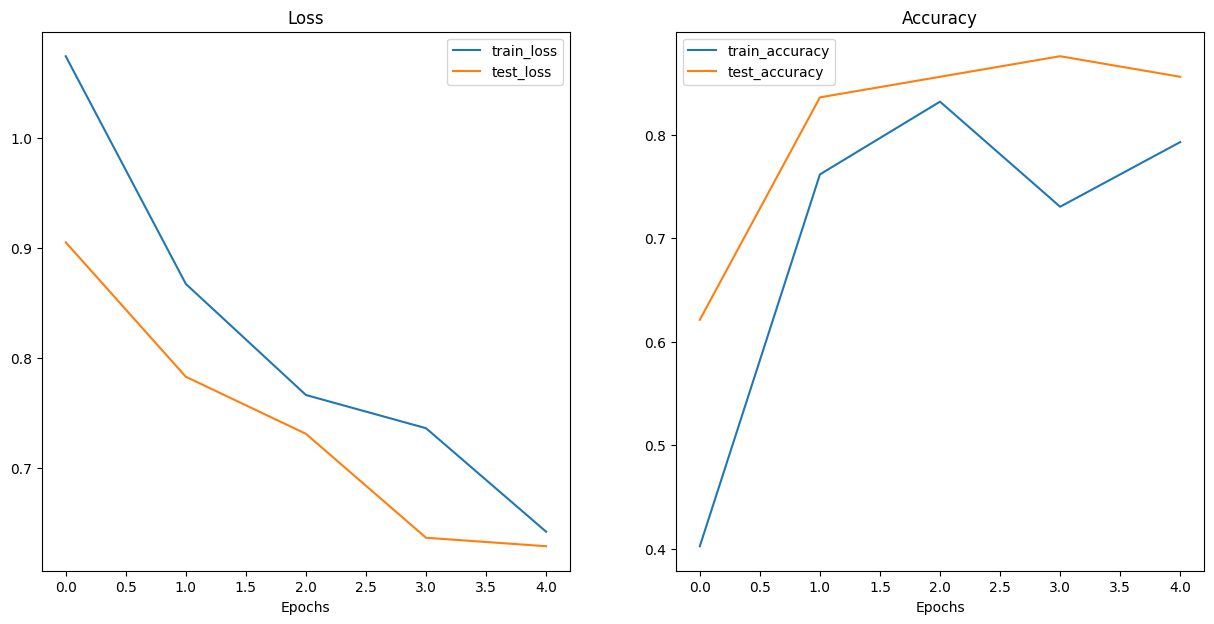

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(result)

## 6. Make predictions

Make sure our images have:

- **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
- **Same datatype** - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
- **Same device** - If our images are on a different device to our model, we'll get device errors.
- **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

In [25]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

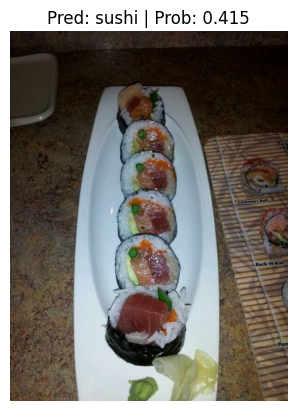

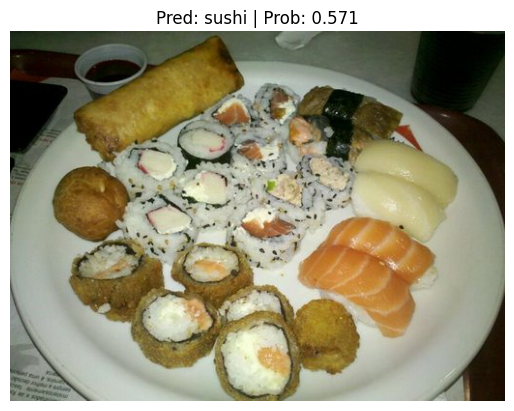

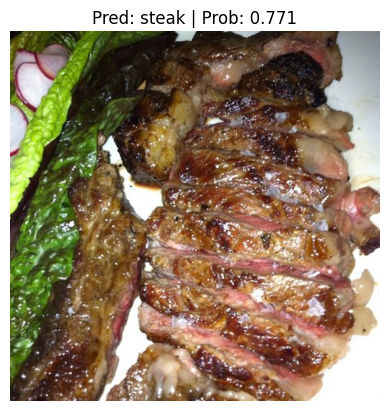

In [26]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))